# 2D section inversion:
## Forward Model 1D: Empymod
## Inversion 1D: Pygimli inversion
## No lateral constraints

In [1]:
#%matplotlib notebook

In [21]:
import empymod
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg

Dualem coil configurations:

In [22]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meter height from ground surface to center of coil
rad = 0.08 # Define radius of coil

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers =[offsets-rad, offsets+rad, np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets+0.1, offsets*0, height]

# Frequency

freq = 9000

In [23]:
def EMforward_(thick1, thick2, res1, res2, res3, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    surface = 0
    depth = [surface, thick1, thick1 + thick2]
    res_air = 2e14
    res = [res_air, res1, res2, res3]
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)
    
    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)

#    P_HCP = -np.real(HCP_Hs/HCP_Hp)
#    P_VCP = np.real(VCP_Hs/VCP_Hp)
#    P_PRP = np.real(PRP_Hs/PRP_Hp)
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))

In [24]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

resistivities = [10,50,10]
res = np.ones((npos, nlayer))*resistivities
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50



In [25]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotResistivities(thk1, thk2, res, npos, ny, Model):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    resy = np.zeros((npos, ny))

    # Resistivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            resy[i, y1] = res[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            resy[i, y2] = res[i, 1]
            y2 += 1
            if y2 == 50:
                break
        resy[i, y2:] = res[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(resy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin=10, vmax=50)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Resistivity [Ohm . m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, resy

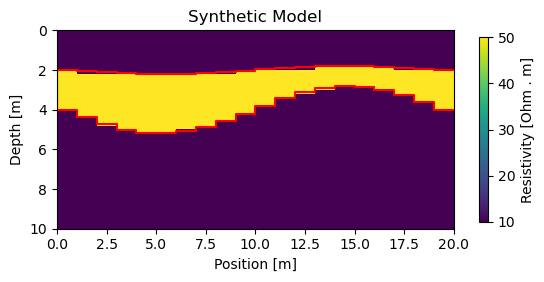

In [26]:
#Plot synthetic model

depth, resy = PlotResistivities(thk1, thk2, res, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')




In [27]:
# Create data to normalize

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    data.append(EMforward_(model_i[0],model_i[1],model_i[2],model_i[3],model_i[4])) # creating data

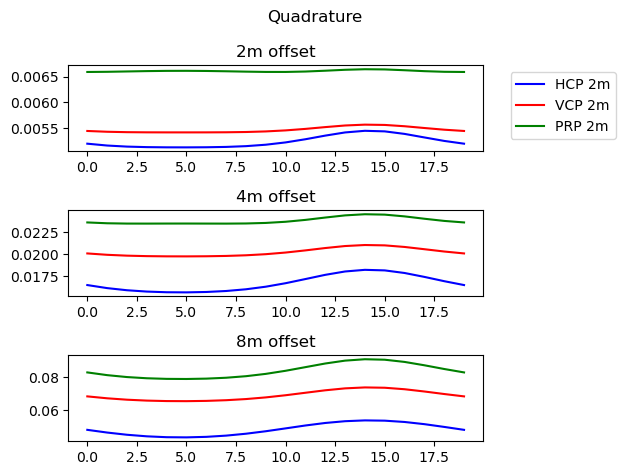

In [28]:
# Let's plot the data

data = np.array(data)
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data[:,0], 'b',label='HCP 2m')
ax1.plot(data[:,3], 'r',label='VCP 2m')
ax1.plot(data[:,6], 'g',label='PRP 2m')
ax1.set_title('2m offset')
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax2.plot(data[:,1], 'b',label='HCP 4m')
ax2.plot(data[:,4], 'r',label='VCP 4m')
ax2.plot(data[:,7], 'g',label='PRP 4m')
ax2.set_title('4m offset')

ax3.plot(data[:,2], 'b',label='HCP')
ax3.plot(data[:,5], 'r',label='VCP')
ax3.plot(data[:,8], 'g',label='PRP')
ax3.set_title('8m offset')

fig.suptitle('Quadrature')
plt.tight_layout()

In [29]:
# Calculate normalization by coil and OP /IP

data = np.array(data)

# data shape is (npos, geometries * 2) 

Q_HCP_2 = data[:,0]
Q_HCP_4 = data[:,1]
Q_HCP_8 = data[:,2]
Q_VCP_2 = data[:,3]
Q_VCP_4 = data[:,4]
Q_VCP_8 = data[:,5]
Q_PRP_2 = data[:,6]
Q_PRP_4 = data[:,7]
Q_PRP_8 = data[:,8]

# Calculate L2 norm

L2_Q_HCP_2 = np.sqrt(np.sum(Q_HCP_2**2))
L2_Q_HCP_4 = np.sqrt(np.sum(Q_HCP_4**2))
L2_Q_HCP_8 = np.sqrt(np.sum(Q_HCP_8**2))

L2_Q_VCP_2 = np.sqrt(np.sum(Q_VCP_2**2))
L2_Q_VCP_4 = np.sqrt(np.sum(Q_VCP_4**2))
L2_Q_VCP_8 = np.sqrt(np.sum(Q_VCP_8**2))

L2_Q_PRP_2 = np.sqrt(np.sum(Q_PRP_2**2))
L2_Q_PRP_4 = np.sqrt(np.sum(Q_PRP_4**2))
L2_Q_PRP_8 = np.sqrt(np.sum(Q_PRP_8**2))

L2_Q_HCP = np.hstack((L2_Q_HCP_2, L2_Q_HCP_4, L2_Q_HCP_8))
L2_Q_VCP = np.hstack((L2_Q_VCP_2, L2_Q_VCP_4, L2_Q_VCP_8))
L2_Q_PRP = np.hstack((L2_Q_PRP_2, L2_Q_PRP_4, L2_Q_PRP_8))

L2 = np.stack((L2_Q_HCP, L2_Q_VCP, L2_Q_PRP))

In [30]:
## Define Analytic normalized forwards

def EMforward_norm(thick1, thick2, res1, res2, res3, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    surface = 0
    depth = [surface, thick1, thick1 + thick2]
    res_air = 2e14
    res = [res_air, res1, res2, res3]
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)
   
    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)/L2[0]
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)/L2[1]
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)/L2[2]
   
    return np.hstack((Q_HCP, Q_VCP, Q_PRP))


In [31]:
# Parameters for initial model

resistivities_ini = [10, 10, 10]
res_ini = np.ones((npos, nlayer))*resistivities_ini
thk1_ini = np.ones(npos)*3
thk2_ini = np.ones(npos)*4


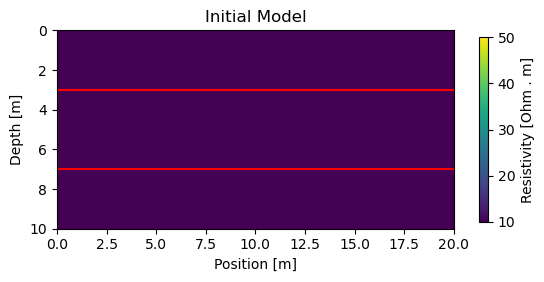

In [32]:
# Plot initial model

depth_ini, resy_ini = PlotResistivities(thk1_ini, thk2_ini, res_ini, npos, ny, 'Initial Model')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,1], depth_ini[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth_ini[0,1], depth_ini[:,2], depth_ini[-1,2])),'r')

Set-up Inversion

In [33]:
# Create forward modeller class

class EMforward(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, x):
        thk1 = x[0]
        thk2 = x[1]
        res1 = x[2]
        res2 = x[3]
        res3 = x[4]
        
        Z = EMforward_norm(thk1, thk2, res1, res2, res3)
                           
        return Z
               
    def createStartModel(self, dataVals):
        
        thk_ini = [3, 4]
        res_ini = [12, 15, 18]
        x0 = thk_ini + res_ini
        return np.array(x0)

In [34]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLog()  # log-transform ensures thk>0

# Create inversion

EMf = EMforward()
invEM = pg.Inversion()
invEM.setForwardOperator(EMf)

invEM.transModel = transModel
invEM.transData = transData


In [35]:
# Inputs for inversion:

# Create empty array for true model in each position
model = []

# Create empty array for true data in each position
data_norm = []

for i in range(npos):
    model_i = np.array([thk1[i][0], thk2[i][0]]+resistivities) # True model 
    model.append(model_i)
    data_norm.append(EMforward_norm(model_i[0], model_i[1], model_i[2], model_i[3], model_i[4])) # creating data

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_norm[0]) * error

In [36]:
# Start inversion

model_est_list =[] # empty array to store the model estimated
chi2hist = [] # empty array to store the chi2 history
modelhist = [] # empty array to store the model history

for i in range(npos):
    
    dataE = np.array(data_norm[i]).copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = invEM.run(dataE, relativeError, verbose=False, lam=1, maxIter=40)
    chi2hist.append(invEM.chi2History)
    modelhist.append(invEM.modelHistory)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr = np.array(model_est_list)

05/12/22 - 14:46:25 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
05/12/22 - 14:46:26 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
05/12/22 - 14:46:27 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:28 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
05/12/22 - 14:46:29 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
05/12/22 - 14:46:29 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:30 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:31 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:31 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:32 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:33 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:33 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:34 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:35 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:36 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:37 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]
05/12/22 - 14:46:38 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:39 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:39 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


05/12/22 - 14:46:40 - pyGIMLi - INFO - Created startmodel from forward operator: [ 3  4 12 15 18]


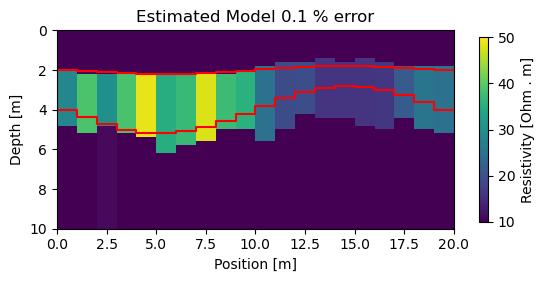

In [37]:
# Plot estimated model

depth_,resy_ = PlotResistivities(model_est_arr[:,0], model_est_arr[:,1], model_est_arr[:,2:] , npos, ny,
                                 'Estimated Model ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')



In [38]:
# Let's compare the two datasets

# Calculate data estimated model

data_est =[]

for i in range(npos):
    model_i = model_est_arr[i] # True model 
    data_est.append(EMforward_norm(model_i[0], model_i[1], model_i[2], model_i[3], model_i[4])) # creating data

data_true = np.array(data_norm)
data_est = np.array(data_est)


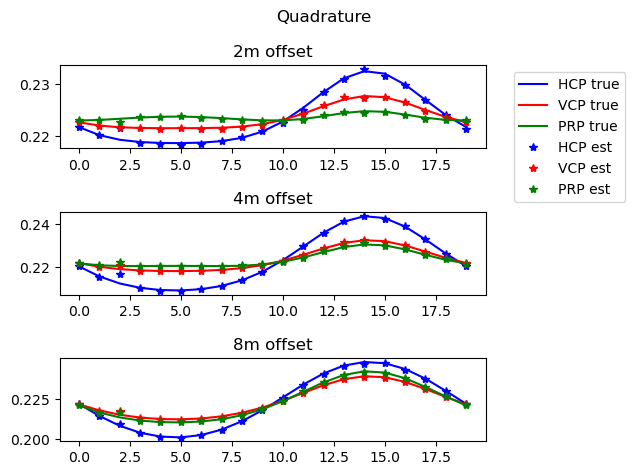

In [39]:
# Let's compare the data
fig, (ax1, ax2, ax3)=plt.subplots(3,1)

ax1.plot(data_true[:,0], 'b',label='HCP true')
ax1.plot(data_true[:,3], 'r',label='VCP true')
ax1.plot(data_true[:,6], 'g',label='PRP true')
ax1.plot(data_est[:,0], '*b',label='HCP est')
ax1.plot(data_est[:,3], '*r',label='VCP est')
ax1.plot(data_est[:,6], '*g',label='PRP est')
ax1.set_title('2m offset')

ax2.plot(data_true[:,1], 'b',label='HCP 4m true')
ax2.plot(data_true[:,4], 'r',label='VCP 4m true')
ax2.plot(data_true[:,7], 'g',label='PRP 4m true')
ax2.plot(data_est[:,1], '*b',label='HCP 4m est')
ax2.plot(data_est[:,4], '*r',label='VCP 4m est')
ax2.plot(data_est[:,7], '*g',label='PRP 4m est')
ax2.set_title('4m offset')

ax3.plot(data_true[:,2], 'b',label='HCP true')
ax3.plot(data_true[:,5], 'r',label='VCP true')
ax3.plot(data_true[:,8], 'g',label='PRP true')
ax3.plot(data_est[:,2], '*b',label='HCP est')
ax3.plot(data_est[:,5], '*r',label='VCP est')
ax3.plot(data_est[:,8], '*g',label='PRP est')
ax3.set_title('8m offset')
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

fig.suptitle('Quadrature')
plt.tight_layout()

Text(0, 0.5, 'chi2')

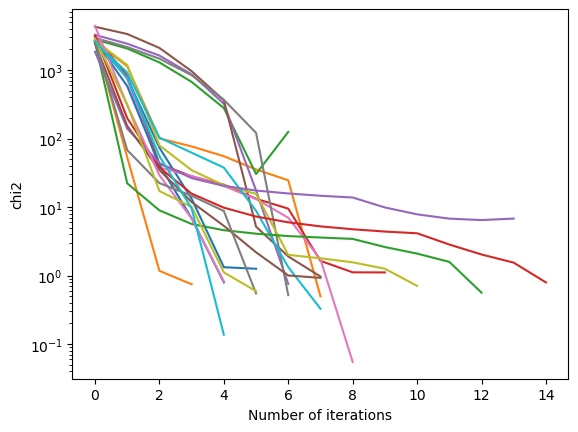

In [40]:
for i in range(len(chi2hist)):
    plt.semilogy(chi2hist[i])
plt.xlabel('Number of iterations')
plt.ylabel('chi2')